## Assignment #4

* Release date: 2023/11/29 Wed
* Due date: **2023/12/06 Wed 23:59** (will not accept late submission)
* Submittion format: notebook file which can be executed in Colab environment
* Weighting: 10% (total 100 pts)

* Sentiment classification model using IMDB dataset
  * Compare LSTM and GRU models with **pretrained embedding from Glove**
  * You can download Glove model from the below link.
    * https://drive.google.com/open?id=1NgMR-bnt02gYTr44BVTo2fRePastYypW

> ### Prepare the dataset


In [36]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [37]:
# construct embedding matrix from pretrained Glove model
from keras.preprocessing.text import Tokenizer
import numpy as np
from google.colab import drive
import os

word_index = imdb.get_word_index()

drive.mount('/content/gdrive')
glove_dir = '/content/gdrive/My Drive/AI'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# preparing the GloVe word-embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if i < max_features:
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 400000 word vectors.


> ### (30pts) Train LSTM model

* Try to find the optimal network architecture that contains LSTM layer.
  * Use **pretrained embedding from Glove** and **freeze** it during training.
  * You can design the architecture whatever you want.
  * However, the validation accuracy of the model should exceed 75%.
  * Use randomly selected 20% of training dataset as validation dataset.
* Plot training/validation loss curve and training/validation accuracy curve.

In [38]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense
from keras import callbacks

'''
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.summary()
'''
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False



#save each model per epoch
filepath = '/content/gdrive/My Drive/AI/model.{epoch:02d}.hdf5'
callback = callbacks.ModelCheckpoint(filepath)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    callbacks = [callback],
                    validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 lstm_4 (LSTM)               (None, 32)                17024     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1017057 (3.88 MB)
Trainable params: 1017057 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
157/157 [==============================] - 6s 22ms/step - loss: 0.6889 - acc: 0.5343 - val_loss: 0.6815 - val_acc: 0.5530
Epoch 2/30
157/157 [==============================] - 3s 18ms/step - loss: 0.6725 - acc: 0.5770 - val_loss: 0.6605 - val_acc: 0.6004
Epoch 3/30
157

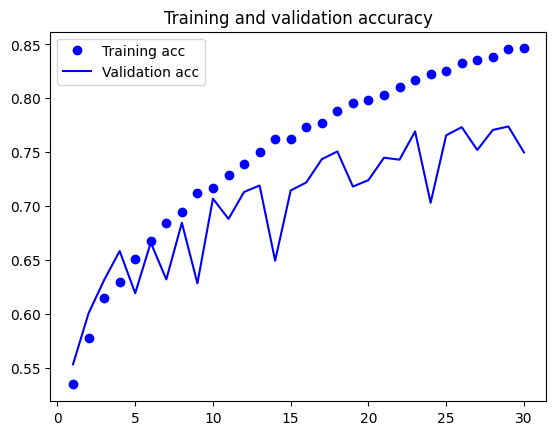

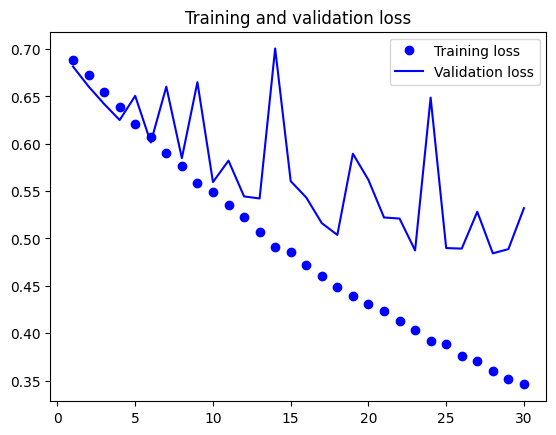

In [40]:
# Plot training/validation loss curve and training/validation accuracy curve.

# plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
# history.history['val_acc']
above_thres = [i for i,v in enumerate(history.history['val_acc']) if v>0.75]
print(above_thres)
minDiff = [history.history['acc'][i]-history.history['val_acc'][i] for i in above_thres]
print(minDiff)
min(minDiff)


[17, 22, 24, 25, 26, 27, 28]
[0.0377500057220459, 0.04754996299743652, 0.06000000238418579, 0.0596500039100647, 0.08355003595352173, 0.06814998388290405, 0.0722000002861023]


0.0377500057220459

* With the selected architecture, compute the final performance on test dataset.

In [54]:
# epoch 18 is the best
model.load_weights('/content/gdrive/My Drive/AI/model.18.hdf5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 7s 9ms/step - loss: 0.4999 - acc: 0.7514


[0.4998994469642639, 0.7514399886131287]

> ### (30pts) Train GRU model

* Again, try to find the optimal network architecture that contains GRU layer.
  * Use **pretrained embedding from Glove** and **freeze** it during training.
  * You can design the architecture whatever you want.
  * However, the validation accuracy of the model should exceed 75%.
  * Use randomly selected 20% of training dataset as validation dataset.
* Plot training/validation loss curve and training/validation accuracy curve.

In [43]:
from keras import callbacks
from keras.models import Sequential
from keras.layers import GRU, Embedding, Dense

modelGRU = Sequential()
modelGRU.add(Embedding(max_features, embedding_dim, input_length=maxlen))
modelGRU.add(GRU(32))
modelGRU.add(Dense(1, activation='sigmoid'))
modelGRU.summary()

modelGRU.layers[0].set_weights([embedding_matrix])
modelGRU.layers[0].trainable = False

# loading the GloVe embeddings in the model
modelGRU.layers[0].set_weights([embedding_matrix])
modelGRU.layers[0].trainable = False

#save each model per epoch
filepath = '/content/gdrive/My Drive/AI/modelGRU{epoch:02d}.hdf5'
callback = callbacks.ModelCheckpoint(filepath)


modelGRU.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

historyGRU = modelGRU.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    callbacks = [callback],
                    validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 gru_3 (GRU)                 (None, 32)                12864     
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1012897 (3.86 MB)
Trainable params: 1012897 (3.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
157/157 [==============================] - 6s 24ms/step - loss: 0.6882 - acc: 0.5421 - val_loss: 0.6980 - val_acc: 0.5232
Epoch 2/30
157/157 [==============================] - 4s 27ms/step - loss: 0.6712 - acc: 0.5796 - val_loss: 0.6708 - val_acc: 0.5760
Epoch 3/30
157

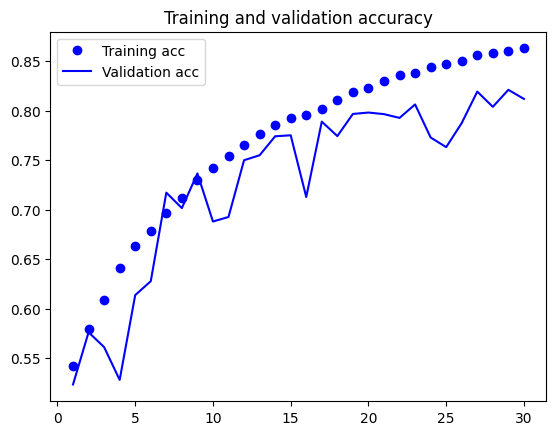

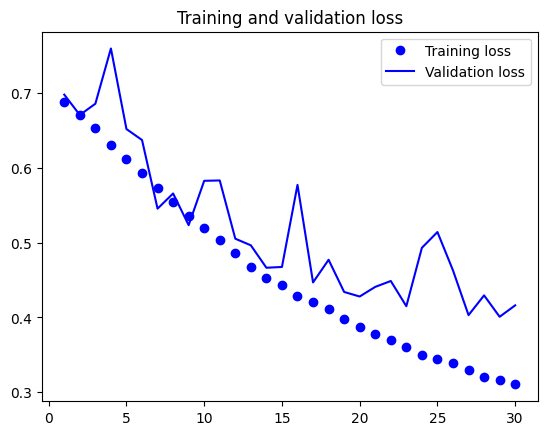

In [44]:
# Plot training/validation loss curve and training/validation accuracy curve.

# plotting the results
import matplotlib.pyplot as plt

acc = historyGRU.history['acc']
val_acc = historyGRU.history['val_acc']
loss = historyGRU.history['loss']
val_loss = historyGRU.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [46]:
above_thres = [i for i,v in enumerate(historyGRU.history['val_acc']) if v>0.75]
print(above_thres)
minDiff = [historyGRU.history['acc'][i]-historyGRU.history['val_acc'][i] for i in above_thres]
print(minDiff)
min(minDiff)

[12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0.021400034427642822, 0.011699974536895752, 0.017949998378753662, 0.013100028038024902, 0.036650002002716064, 0.02265000343322754, 0.02445000410079956, 0.03380000591278076, 0.0428999662399292, 0.03214997053146362, 0.07144999504089355, 0.0840499997138977, 0.06255000829696655, 0.03689998388290405, 0.05460000038146973, 0.03949999809265137, 0.050999999046325684]


0.011699974536895752

* With the selected architecture, compute the final performance on test dataset.

In [53]:
# epoch 14 is the best
modelGRU.load_weights('/content/gdrive/My Drive/AI/modelGRU14.hdf5')
modelGRU.evaluate(x_test, y_test)

782/782 [==============================] - 7s 9ms/step - loss: 0.4751 - acc: 0.7678


[0.475057452917099, 0.767799973487854]

> ### (40pts) Training the model without pretrained embeddings, and compare it with the above models

* (10pts) Training the model (choose one of your previous models, LSTM or GRU) with randomly initialized and trainable embeddings.
  * This model should have exactly the same configuration as your previous model.
* (10pts) Plot training/validation loss curve and training/validation accuracy curve.
* (20pts) Compare the performance with the model based on pretrained embeddings and discuss the effect of such pretrained embeddings in this case.

In [48]:
from keras import callbacks
from keras.models import Sequential
from keras.layers import GRU, Embedding, Dense

modelNoEmbed = Sequential()
modelNoEmbed.add(Embedding(max_features, embedding_dim, input_length=maxlen))
modelNoEmbed.add(GRU(32))
modelNoEmbed.add(Dense(1, activation='sigmoid'))
modelNoEmbed.summary()

modelNoEmbed.layers[0].set_weights([embedding_matrix])
modelNoEmbed.layers[0].trainable = False

#except loading the GloVe embeddings in the model

#save each model per epoch
filepath = '/content/gdrive/My Drive/AI/modelNoEmbed{epoch:02d}.hdf5'
callback = callbacks.ModelCheckpoint(filepath)


modelNoEmbed.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

historyNoEmbed = modelNoEmbed.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    callbacks = [callback],
                    validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 gru_4 (GRU)                 (None, 32)                12864     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1012897 (3.86 MB)
Trainable params: 1012897 (3.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
157/157 [==============================] - 6s 27ms/step - loss: 0.6871 - acc: 0.5457 - val_loss: 0.6769 - val_acc: 0.5724
Epoch 2/30
157/157 [==============================] - 4s 23ms/step - loss: 0.6691 - acc: 0.5809 - val_loss: 0.6937 - val_acc: 0.5498
Epoch 3/30
157

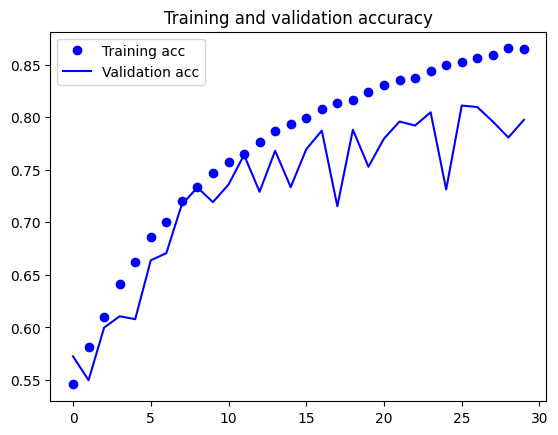

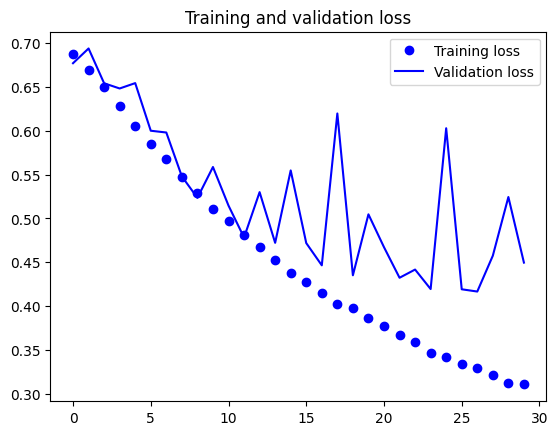

In [49]:
import matplotlib.pyplot as plt

acc = historyNoEmbed.history['acc']
val_acc = historyNoEmbed.history['val_acc']
loss = historyNoEmbed.history['loss']
val_loss = historyNoEmbed.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [50]:
above_thres = [i for i,v in enumerate(historyGRU.history['val_acc']) if v>0.75]
print(above_thres)
minDiff = [historyGRU.history['acc'][i]-historyGRU.history['val_acc'][i] for i in above_thres]
print(minDiff)
min(minDiff)

[12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0.021400034427642822, 0.011699974536895752, 0.017949998378753662, 0.013100028038024902, 0.036650002002716064, 0.02265000343322754, 0.02445000410079956, 0.03380000591278076, 0.0428999662399292, 0.03214997053146362, 0.07144999504089355, 0.0840499997138977, 0.06255000829696655, 0.03689998388290405, 0.05460000038146973, 0.03949999809265137, 0.050999999046325684]


0.011699974536895752

In [52]:
# epoch 14 is the best
modelNoEmbed.load_weights('/content/gdrive/My Drive/AI/modelNoEmbed14.hdf5')
modelNoEmbed.evaluate(x_test, y_test)

782/782 [==============================] - 8s 10ms/step - loss: 0.4748 - acc: 0.7693


[0.4748082160949707, 0.769320011138916]

If pre-trained word embedding is not used, the model will learn the embedding of input tokens specialized for the task.

In my experiment, the base model shows slightly better performance and it seems that it is because of the abundant number of data samples.